In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [3]:
data = pd.read_csv("D:/2024-1学年/sph6004/assignment_2/df_imputed_nodrop.csv")

data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

deceased_df = data[data['icu_death'] == 0]   #1是死亡的
deceased_df_sorted = deceased_df.sort_values(by=['id', 'charttime'])

D:\anaconda\envs\tensorflow\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


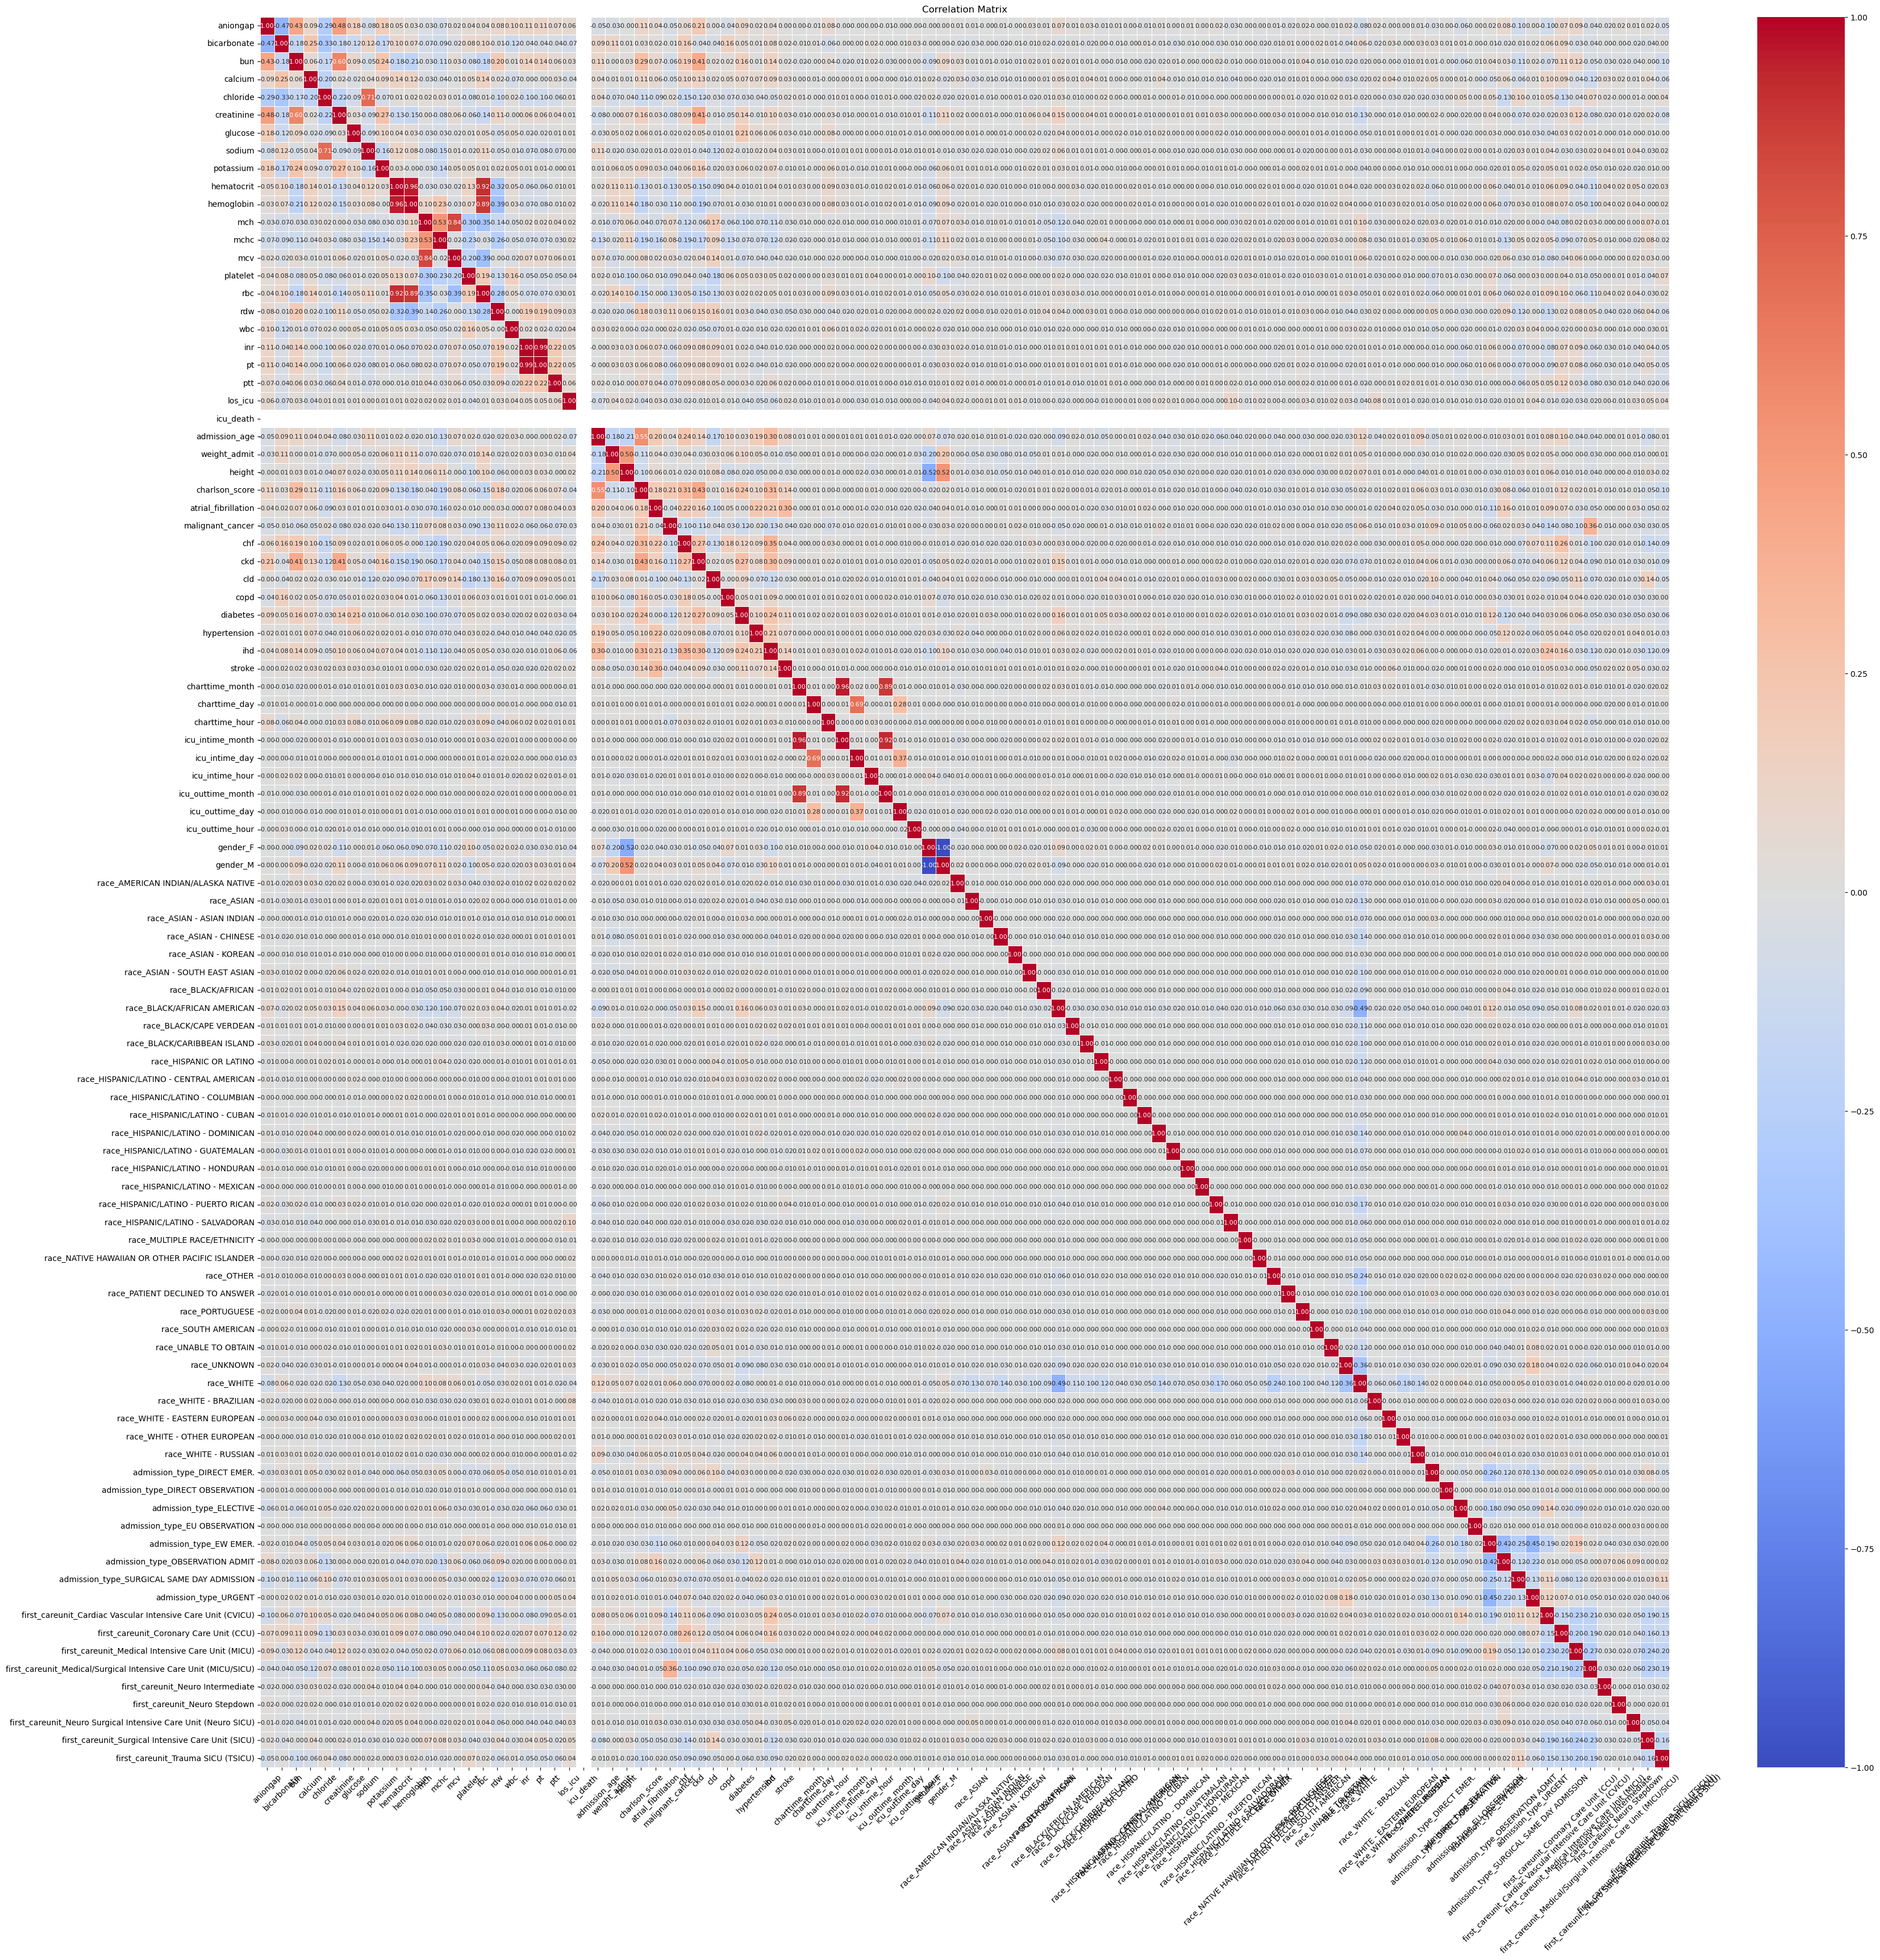

In [5]:
numeric_df = deceased_df_sorted.select_dtypes(include=[np.number])
numeric_df.drop(columns=['id'], inplace=True)

correlation_matrix = numeric_df.corr()
correlation_with_los_icu = correlation_matrix['los_icu'].sort_values(key=abs, ascending=False)

top_features = correlation_with_los_icu[1:31].index.tolist()
df_selected_features = deceased_df_sorted[top_features + ['los_icu']]

X = df_selected_features.drop('los_icu', axis=1)
y = df_selected_features['los_icu']

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 40))  
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
plt.title('Correlation Matrix')
plt.xticks(rotation=45)  
plt.show()


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(64, activation='relu'),
    Dense(1)  
])

In [5]:

model.compile(optimizer='adam', loss='mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta=0.001, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, mode='min', verbose=1, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=140, validation_split=0.2, batch_size=32, verbose=1, callbacks=[early_stopping, reduce_lr])

model.fit(X_train_reshaped, y_train, batch_size=64, epochs=140, validation_split=0.2)

predictions = model.predict(X_test_reshaped)
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
from sklearn.metrics import r2_score

y_mean = np.mean(y_test)

tss = np.sum((y_test - y_mean) ** 2)

rss = np.sum((y_test - predictions.flatten()) ** 2)

r_squared = 1 - (rss / tss)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r_squared}')


Epoch 1/140
1621/1621 [==============================] - 5s 3ms/step - loss: 37.8983 - val_loss: 41.2852 - lr: 0.0010
Epoch 2/140
1621/1621 [==============================] - 5s 3ms/step - loss: 36.7184 - val_loss: 40.8991 - lr: 0.0010
Epoch 3/140
1621/1621 [==============================] - 5s 3ms/step - loss: 54.1412 - val_loss: 41.3664 - lr: 0.0010
Epoch 4/140
1621/1621 [==============================] - 5s 3ms/step - loss: 36.5189 - val_loss: 40.8213 - lr: 0.0010
Epoch 5/140
1621/1621 [==============================] - 5s 3ms/step - loss: 36.1983 - val_loss: 41.6556 - lr: 0.0010
Epoch 6/140
1621/1621 [==============================] - 5s 3ms/step - loss: 36.0808 - val_loss: 41.1411 - lr: 0.0010
Epoch 7/140
1621/1621 [==============================] - 6s 4ms/step - loss: 35.9460 - val_loss: 40.7434 - lr: 0.0010
Epoch 8/140
1621/1621 [==============================] - 8s 5ms/step - loss: 36.4063 - val_loss: 40.4273 - lr: 0.0010
Epoch 9/140
1621/1621 [==============================] -

In [6]:
predictions_df = pd.DataFrame(predictions, columns=['Predicted LOS_ICU'])
y_test_df = pd.DataFrame(y_test, columns=['los_icu'])

predictions_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

comparison_df = pd.concat([y_test_df, predictions_df], axis=1)
print(comparison_df.head())


   los_icu  Predicted LOS_ICU
0     3.19           5.778421
1     6.14           6.847850
2     2.89           4.689031
3    15.57           9.514377
4     2.88           4.551378
